# SI 671 Data Mining: Methods and Applications

*** 

<font size="10" color="royalblue">**DUE:** Oct 21, 2020 (WED)</font>

Speed-dating: Match Prediction and Recommendation
***


```
Yijing Chen,   
Oct 18, 2020
```

In [1]:
import pandas as pd
import numpy as np
import sklearn
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

***
Data Description:

1. `trainML.csv`: This file contains the training data for Part 2 of the homework. It contains 3808 observations and 61 columns/features. The column keys are described in the file SpeedDatingDataKey.pdf.
2. `testML.csv`: This file contains the test data for Part 2 of the homework. Please insert your prediction results in the match column in the file.
3. `trainRec.csv`: This file contains the training data for Part 3 of the homework. The complete training data set has 38340 observations. It contains ratings on a scale of 1-10 given by an attendee with id `iid` to their partner with id `pid`.
4. `testRec.csv`: This file contains the test data for Part 3 of the homework. Please insert your predicted ratings in the rate column in the file.
***

In [3]:
# load dataset
trainML = pd.read_csv("trainML.csv")
testML = pd.read_csv("testML.csv")
trainRec = pd.read_csv("trainRec.csv")
testRec = pd.read_csv("testRec.csv")

## part 1: data exploration (15 points)

Perform basic EDA on `trainML.csv` and `trainRec.csv`. Paper link [here](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.87.277&rep=rep1&type=pdf).

**Main deliverable:** a step-by-step exploration of data along with text describing your conclusions in your Jupyter Notebook. 

**Notes from Piazza:**  
@91 Exploration or model building is ALWAYS done on training data! You're never supposed to look at test data in real-life data science roles. We just provided the test file so that you can add your correct predicted labels there.

<font color="royalblue">
    
### dataframe basics
    
The `trainML` dataframe has 3808 rows, each representing a unique pair of participant-partner (the ordering here matters). There are 257 participants in total, and everyone has been paired up with at least one other participant in the training set.
    
The `trainRec` dataframe has 38340 rows, each representing a unique pair of participant-partner rating (the ordering matters). There are 277 participants included. The distribution of rates is symmetrical, with most scores fall between 6 and 8. The average score is 6.39.

</font>

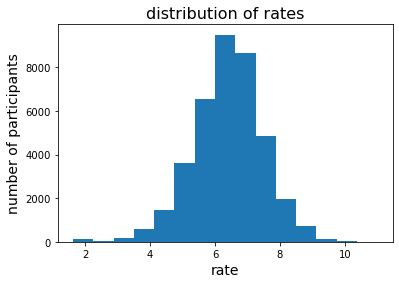

average rate = 6.3900284298382894
median rate = 6.400000000000001


In [4]:
# trainRec.groupby(["pid","iid"]).mean()
# trainRec.pid.nunique()  # 277
# trainRec.iid.nunique()  # 277
plt.hist(trainRec.rate, bins=15)
plt.xlabel("rate", fontsize=14)
plt.ylabel("number of participants", fontsize=14)
plt.title("distribution of rates", fontsize=16)
plt.show()
print("average rate =", np.mean(trainRec.rate))
print("median rate =", np.median(trainRec.rate))

In [5]:
print("training size =", len(trainML))
print("number of unique iid =", len(trainML.groupby("iid").count()))
print("number of unique pairs =", len(trainML.groupby(["iid","pid"]).count()))
# each row in the dataframe represent a unique pair of partners

print("\n")
print("columns:", trainML.columns)

training size = 3808
number of unique iid = 257
number of unique pairs = 3808


columns: Index(['gender', 'match', 'samerace', 'age_o', 'race_o', 'pf_o_att',
       'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'attr_o',
       'sinc_o', 'intel_o', 'fun_o', 'met_o', 'age', 'field', 'race',
       'imprace', 'imprelig', 'from', 'goal', 'date', 'go_out', 'career',
       'career_c', 'sports', 'tvsports', 'exercise', 'dining', 'museums',
       'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
       'movies', 'concerts', 'music', 'shopping', 'yoga', 'attr1_1', 'sinc1_1',
       'intel1_1', 'fun1_1', 'amb1_1', 'attr3_1', 'sinc3_1', 'fun3_1',
       'intel3_1', 'attr', 'sinc', 'intel', 'fun', 'met', 'iid', 'pid',
       'shar1_1'],
      dtype='object')


In [6]:
# everyone has been paired up with at least someone else in the training set
set(trainML.pid.unique()) == set(trainML.iid.unique())

True

In [7]:
# (1,29) and (29,1) are both recorded in this dataframe
# (ordering of participant-partner matters)

# trainML[trainML["iid"]==1][["iid", "pid", "attr1_1", "sinc1_1"]]
# trainML[trainML["pid"]==1][["iid", "pid", "pf_o_att", "pf_o_sin"]]

<font color="royalblue">
    
### column exploration

#### by participant (individual-level statistics)
    
</font>

In [8]:
# split the columns into different categories
partner_demg = ["age_o", "race_o"]
partner_pref = ["pf_o_att", "pf_o_sin", "pf_o_int", "pf_o_fun", "pf_o_amb", "pf_o_sha"]
partner_rate = ["attr_o", "sinc_o", "intel_o", "fun_o"]

pticipt_demg = ["gender", "age", "field", "race", "from"]
pticipt_impt = ["imprace", "imprelig"]
pticipt_misc = ["goal", "date", "go_out", "career", "career_c"]
pticipt_hobby = ["sports", "tvsports", "exercise", "dining", "museums", "art", "hiking", "gaming", "clubbing",
                "reading", "tv", "theater", "movies", "concerts", "music", "shopping", "yoga"]
pticipt_pref = ["attr1_1", "sinc1_1", "intel1_1", "fun1_1", "amb1_1", "shar1_1"]
pticipt_self = ["attr3_1", "sinc3_1", "intel3_1", "fun3_1"]
pticipt_rate = ["attr", "sinc", "intel", "fun"]

gender: Counter({0: 129, 1: 128})
age mean: 26.59760956175299
age mode: [27.]
youngest: 18.0
oldest: 55.0


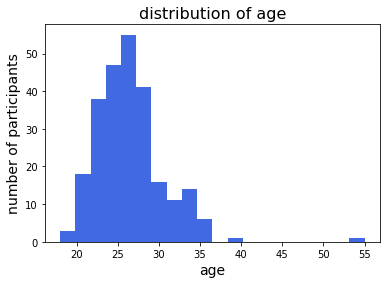

In [9]:
# by participant (individual-level)
pticipt = trainML[["iid"] + pticipt_demg + pticipt_impt + pticipt_misc + pticipt_hobby + pticipt_pref + pticipt_self].copy()  

# these values should be the same for a single participant across different partners
# so I aggregated by iid and take the first in each group:
aggr_pticipt = pticipt.groupby("iid").first().reset_index()

print("gender:", Counter(aggr_pticipt.gender))
print("age mean:", np.mean(aggr_pticipt.age))
print("age mode:", stats.mode(aggr_pticipt.age)[0])
print("youngest:", min(aggr_pticipt.age))
print("oldest:", max(aggr_pticipt.age))
plt.hist(aggr_pticipt.age, color="royalblue", bins=20)
plt.xlabel("age", fontsize=14)
plt.ylabel("number of participants", fontsize=14)
plt.title("distribution of age", fontsize=16)
plt.show()

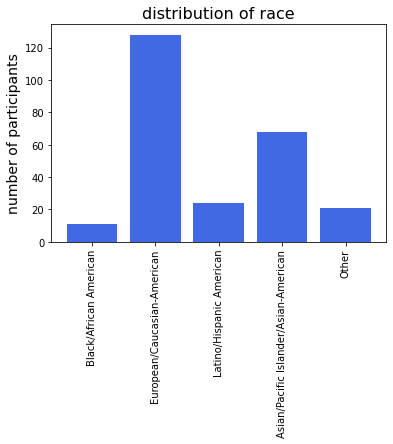

In [10]:
# race
race_dict = {1: "Black/African American",
             2: "European/Caucasian-American",
             3: "Latino/Hispanic American",
             4: "Asian/Pacific Islander/Asian-American",
             5: "Native American",
             6: "Other"}

aggr_race = aggr_pticipt.groupby("race").nunique("iid")[["iid"]].reset_index()
aggr_race["race"] = aggr_race["race"].astype(int)
aggr_race["race_c"] = aggr_race["race"].map(lambda x: race_dict[x])
plt.bar(aggr_race.race_c, aggr_race.iid, color="royalblue")
plt.ylabel("number of participants", fontsize=14)
plt.title("distribution of race", fontsize=16)
plt.xticks(rotation=90)
plt.show()

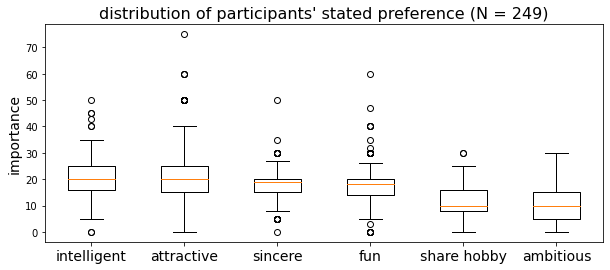

In [11]:
# what you look for in the opposite sex

# drop missing values
pticipt_pref_df = aggr_pticipt[pticipt_pref].dropna() 
# drop irregular values (negative rating)
pticipt_pref_df = pticipt_pref_df.drop([int(pticipt_pref_df[pticipt_pref_df.values<0].index.values)])

meds = pticipt_pref_df.median()
meds.sort_values(ascending=False, inplace=True)
# print(meds.index)
pticipt_pref_bp = [pticipt_pref_df[x].values.tolist() for x in list(meds.index)]
fig,ax = plt.subplots(figsize=(10,4))
ax.boxplot(pticipt_pref_bp)
ax.set_xticklabels(["intelligent", "attractive", "sincere", "fun", "share hobby", "ambitious"], fontsize=14)
plt.ylabel("importance", fontsize=14)
plt.title(f"distribution of participants' stated preference (N = {len(pticipt_pref_df)})", fontsize=16)
plt.show()

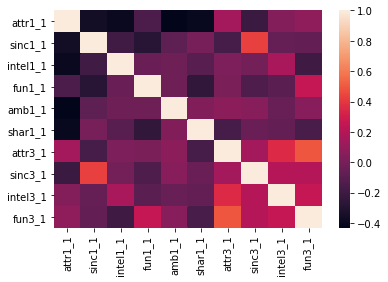

In [12]:
# correlation heatmap of participants' self-rated and preferred qualities

pticipt_corr_df = aggr_pticipt[pticipt_pref + pticipt_self].dropna()
pticipt_corr_df = pticipt_corr_df.drop([int(pticipt_corr_df[pticipt_corr_df.values<0].index.values)])
# print(pticipt_corr_df.corr())
sns.heatmap(pticipt_corr_df.corr())
plt.show()  
# these features do not seem to be strongly correlated
# sinc3_1 and sinc1_1 have a relatively higher (but still noisy) correlation value

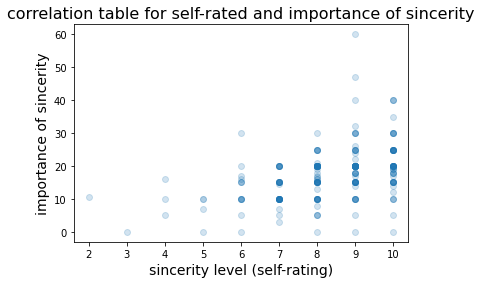

(0.4314053225436856, 1.0417766558735845e-12)


In [13]:
plt.scatter(pticipt_corr_df.sinc3_1, pticipt_corr_df.sinc1_1, alpha=0.2)
plt.xlabel("sincerity level (self-rating)", fontsize=14)
plt.ylabel("importance of sincerity", fontsize=14)
plt.title("correlation table for self-rated and importance of sincerity", fontsize=16)
plt.show()
print(stats.pearsonr(pticipt_corr_df.sinc3_1, pticipt_corr_df.sinc1_1))

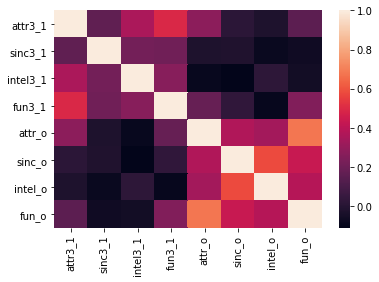

In [14]:
# correlation heatmap of participants' self ratings and partner ratings (averaged)
 
pticipt_corr_df2 = trainML[["iid"] + pticipt_self + partner_rate].dropna().copy()
pticipt_corr_df2 = pticipt_corr_df2.groupby("iid").mean()
pticipt_corr_df2.corr()
sns.heatmap(pticipt_corr_df2.corr())
plt.show()

# left bottom and right top --> dark
# weak/negligible correlation between participants' self-ratings and ratings from their partners

<font color="royalblue">
             

#### by pair (pair-level statistics)
    
</font>

In [15]:
match_table = trainML[["match", "iid", "pid"]].copy()  # len = 3808

# create a unique pair id for each pair of partners (len should be 3808/2)
match_table["pair_id"] = match_table.apply(lambda x: str(min([x.iid, x.pid])) + str(max([x.iid, x.pid])), axis=1)
# match_table.pair_id.nunique() # 1904 = 3808/2

In [16]:
pair_df = trainML.merge(match_table, on=["iid","pid"])[["match_x", "samerace", "pair_id"]]
pair_df = pair_df.groupby("pair_id").mean()
print("match rate = ", Counter(pair_df.match_x)[1]/len(pair_df), "\n")
pair_samerace = pair_df[pair_df["samerace"]==1]
print("among same-race pairs, match rate =", Counter(pair_samerace.match_x)[1]/len(pair_samerace))
pair_diffrace = pair_df[pair_df["samerace"]==0]
print("among different-race pairs, match rate =", Counter(pair_diffrace.match_x)[1]/len(pair_diffrace))

stats.ttest_ind(pair_samerace.match_x, pair_diffrace.match_x, equal_var = False)
# the difference is not significant



match rate =  0.16491596638655462 

among same-race pairs, match rate = 0.17557251908396945
among different-race pairs, match rate = 0.15932746196957567


Ttest_indResult(statistic=0.8960945433624198, pvalue=0.37037025391078415)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

pair_df = trainML.merge(match_table, on=["iid","pid"])[["iid", "pid", "match_x", "samerace", "pair_id"] + pticipt_hobby]
pair_df_na = pair_df[pair_df.isna().any(axis=1)]
na_id = pair_df_na.iid.unique()
print("will drop records that contain participants or partners:", na_id)
pair_df = pair_df[~pair_df["iid"].isin(na_id)]
pair_df = pair_df[~pair_df["pid"].isin(na_id)]
pair_df["hobby_vec"] = pair_df.apply(lambda x: [x[a] for a in pticipt_hobby], axis=1)
pair_df = pair_df[["hobby_vec", "match_x", "pair_id"]]
aggr_func = {"match_x": lambda x: max(x), "hobby_vec": lambda x: list(x)}
aggr_pair = pair_df.groupby("pair_id").aggregate(aggr_func).reset_index()
aggr_pair["hobby_sim"] = aggr_pair["hobby_vec"].map(lambda x: 
                                                    cosine_similarity(np.array([x[0]]),np.array([x[1]]))[0][0])
aggr_pair.head()

will drop records that contain participants or partners: [489 386 170 299 114]


,pair_id,match_x,hobby_vec,hobby_sim
0,102190,1,"[[1.0, 1.0, 8.0, 8.0, 7.0, 7.0, 6.0, 2.0, 8.0,...",0.886182
1,102219,0,"[[5.0, 8.0, 5.0, 9.0, 9.0, 9.0, 7.0, 1.0, 4.0,...",0.943396
2,102392,0,"[[1.0, 2.0, 1.0, 8.0, 9.0, 9.0, 10.0, 1.0, 1.0...",0.863331
3,102451,0,"[[9.0, 1.0, 6.0, 10.0, 8.0, 6.0, 9.0, 3.0, 6.0...",0.859277
4,102490,0,"[[3.0, 5.0, 3.0, 10.0, 10.0, 7.0, 7.0, 1.0, 8....",0.903777


among matched pairs, average of hobby similarity = 0.8940107499058287
among unmatched pairs, average of hobby similarity = 0.8890838699009134


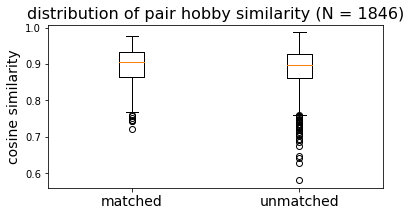

Ttest_indResult(statistic=1.5403443965288282, pvalue=0.12419289627437595)


In [18]:
print("among matched pairs, average of hobby similarity =", np.mean(aggr_pair[aggr_pair["match_x"]==1].hobby_sim))
print("among unmatched pairs, average of hobby similarity =", np.mean(aggr_pair[aggr_pair["match_x"]==0].hobby_sim))

fig,ax = plt.subplots(figsize=(6,3))
plt.boxplot([aggr_pair[aggr_pair["match_x"]==1].hobby_sim, aggr_pair[aggr_pair["match_x"]==0].hobby_sim])
ax.set_xticklabels(["matched", "unmatched"], fontsize=14)
plt.ylabel("cosine similarity", fontsize=14)
plt.title(f"distribution of pair hobby similarity (N = {len(aggr_pair)})", fontsize=16)
plt.show()

print(stats.ttest_ind(aggr_pair[aggr_pair["match_x"]==1].hobby_sim,
                      aggr_pair[aggr_pair["match_x"]==0].hobby_sim,equal_var = False))

<font color="royalblue">

### written conclusion
    

**by participant (individual-level statistics)**
    
- gender: 128 males (`1`) and 129 females (`0`) --> gender ratio ~ 1:1  
- age: most participants are in the range of 25-30, average ~ 26.6, the distribution is slightly right skewed, - with a thin tail stretching to 55 years old (max).  
- race: most are European/Caucasian-American.  
- preference: based on the median value, "intelligence", "attractiveness", and "sincerity" are the top 3 important qualities listed by participants.
- correlation between self-rated and expected qualities: participants' self-rated levels do not seem to be strongly correlated to their expected levels (they are different than what they are looking for); participants who self-reported to be more sincere are more likely to place sincerity in higher priority when looking for partners, but the correlation is not that strong (pearson r = 0.43).
- correlation between self-rated and partner-rated qualities: weak/negligible correlation between participants' self-ratings and ratings from their partners, which means participants' self-perceptions are not really aligned with their impressions on the corresponding partners.

**by pair (pair-level statistics)**
    
- match rate: among 1904 unique pairs of partners, the match rate is 16.49% (sadly).
- same/different race pairs: the match rate among same-race pairs are slightly higher than that in different-race pairs, but the difference is not significant. 
- hobby similarity: for those pairs with a hobby similarity score less than 0.75, they are not likely to match; but the average score of hobby similarity between matched pairs and unmatched pairs are not significantly different. 
    
**handling missing values and outliers:**
- dropped `nan` values using `df.dropna()` (this was performed on the sub-dataframe instead of on the full dataset, so that I can keep as many rows as possible) 
- filtered outliers (e.g., when plotting boxplot, filtered one participant who gave a negative score (negligible effect on the entire distribution))
    
</font>

## part 2: predicting matches (35 points)

You will build and compare machine learning models to predict if participants X and Y who met for the speed-date actually “matched” i.e. after the event finished they did choose to see their date again. Note that our data contains both the observations, when participant X is the “ID” and Y is the “partner ID”, and when Y is the “ID” and X is the “partner ID”. It’s easy to see that this is an **asymmetric prediction task**—X might choose to see Y again but Y might not choose to see X again.

**Notes from Piazza:**  
@88 However, what I mentioned was regarding data imputation while choosing the best model by splitting the training dataset into train and dev sets. For that, it is fine to impute values on the full training set and then split it into train+dev sets as that is all part of the training data. 

<font color="royalblue">

### preprocessing steps: 
    
1. create new dummy columns for categorical variables (`from`, `field`, and `career`) to indicate whether the participant and the partner fall into the same category (except that we already have `samerace`) and dropped old categorical variables.  
2. drop columns
    - `iid` and `pid`
    - `shar1_1` in the training set (the test set doesn't have this variable)
3. impute missing data using the `mean` strategy
4. standardized data using `MinMaxScaler()`
5. split the training set into training/development subset (`test_size=0.25`)
</font>

In [19]:
set(trainML.columns) - set(testML.columns)  # share1_1 is not in testML dataframe (drop this feature)

{'shar1_1'}

In [20]:
# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif

def preprocessing(n_features=10): # ok!
    # get data
    X = trainML.loc[:, (trainML.columns != "match")]
    y = trainML.loc[:, "match"]

    # create dummy variables for categorical columns, then drop categorical columns
    def assign_dummy(a,b):
        if a == b: return 1
        else: return 0

    X = X.merge(X[["iid","from","field","career"]].groupby("iid").first().reset_index(), 
                left_on="pid", right_on="iid")
    X = X.drop(columns="iid_y").rename(columns={"iid_x": "iid"})
    X["samefrom"] = X.apply(lambda x: assign_dummy(x.from_x, x.from_y), axis=1)
    X["samefield"] = X.apply(lambda x: assign_dummy(x.field_x, x.field_y), axis=1)
    X["samecareer"] = X.apply(lambda x: assign_dummy(x.career_x, x.career_y), axis=1)
    X = X.drop(columns=["race_o","from_x","from_y","field_x","field_y","career_x","career_y"])

    # drop id and shar1_1
    X = X.drop(columns=["iid","pid","shar1_1"])
    X_columns = X.columns

    # impute missing data
    imputer = SimpleImputer(strategy="mean")
    X = imputer.fit_transform(X)

    # standardize 
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=X_columns)

#     # select feature (default: top 10 features) 
#     # REMOVED FROM PREPROCESSING!! --> will use gridsearch to determine the best K
#     selector = SelectKBest(score_func=f_classif, k=n_features)
#     X = selector.fit_transform(X, y)
#     dfscores = pd.DataFrame(selector.fit(X,y).scores_)  # print output
#     dfcolumns = pd.DataFrame(X_columns)
#     featureScores = pd.concat([dfcolumns,dfscores], axis=1)
#     featureScores.columns = ["specs","score"]  #naming the dataframe columns
#     print("selected features:")
#     print(featureScores.nlargest(n_features,"score"))  #print 10 best features
#     print("\n")

    # training/validation split
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.25, random_state=2666)
    print("X_train", X_train.shape)
    print("X_dev", X_dev.shape)
    print("y_train", y_train.shape)
    print("y_dev", y_dev.shape)
    
    return X_train, X_dev, y_train, y_dev

<font color="royalblue">

### Predicting models
    
- used `GridSearchCV` to search for the best parameters for all models
- used F1, precision and recall score to evaluate model performance
- further printed out the confusion matrix to look at the classification results
- used cross validation (`cv = 5`) to select optimal models

#### Lasso Regression
    
Results: achieved a precision of 0.77, a recall of 0.82 and an F1 of 0.75. 
    
</font>

In [21]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix


def lasso_reg():
    X_train, X_dev, y_train, y_dev = preprocessing()
    
    pipe = Pipeline([("select", SelectKBest()), ("clf", Lasso())])
    param_grid = [{"select__k": [10, 20, 30, 40], "clf__alpha": np.logspace(-10,10,10)}]
    search = GridSearchCV(pipe, param_grid, cv=5)
    search.fit(X_train, y_train)
    print(f"best parameter: {search.best_params_}")
    
    # finding an optimal decision boundary
    search_clf = search. best_estimator_
    search_clf.fit(X_train, y_train)
    dev_scores = {}
    for this_db in np.arange(0.1, 1, 0.1):
#         print("decision boundary =", this_db)
        train_preds = search_clf.predict(X_train)
        train_preds = [1 if x >= this_db else 0 for x in train_preds]
        dev_preds = search_clf.predict(X_dev)
        dev_preds = [1 if x >= this_db else 0 for x in dev_preds]
        train_f1 = f1_score(y_train, train_preds, average="weighted")  
        dev_f1 = f1_score(y_dev, dev_preds, average="weighted") 
#         print("- f1 for training =", train_f1)
#         print("- f1 for development =", dev_f1)
        dev_scores[this_db] = dev_f1
    
    best_db = max(dev_scores, key=dev_scores.get)
    print("best decision boundary =", best_db)
    dev_preds = search_clf.predict(X_dev)
    dev_preds = [1 if x >= best_db else 0 for x in dev_preds]
    best_dev_f1 = f1_score(y_dev, dev_preds, average="weighted") 
    best_dev_reca = recall_score(y_dev, dev_preds, average="weighted")
    best_dev_prec = precision_score(y_dev, dev_preds, average="weighted")
    print("best weighted F1 =", best_dev_f1)
    print("best weighted recall =", best_dev_reca)
    print("best weighted precision =", best_dev_prec, "\n")
    
    print("confusion matrix:")
    print(confusion_matrix(y_dev, dev_preds))
    
lasso_reg()

X_train (2856, 56)
X_dev (952, 56)
y_train (2856,)
y_dev (952,)
best parameter: {'clf__alpha': 0.0004641588833612782, 'select__k': 20}
best decision boundary = 0.30000000000000004
best weighted F1 = 0.7492228514896305
best weighted recall = 0.8245798319327731
best weighted precision = 0.7687712743325178 

confusion matrix:
[[783   2]
 [165   2]]


<font color="royalblue">

#### Logistic Regression
    
Results: achieved a precision of 0.67, a recall of 0.82 and an F1 of 0.74. 
    
Based on the confusion matrix, the model is not throwing any negative labels. So I added `class_weights="balanced" to see whether that helps. As a results, the "balanced" classifier does have a higher precision, but it dramatically sacrifices the recall and produces a even lower F1. I also tried to set a higher cap for iteration number, but it seems the poor performance is not caused by limited iterations.

</font>

In [22]:
from sklearn.linear_model import LogisticRegression

def logit_reg():
    X_train, X_dev, y_train, y_dev = preprocessing()
    
    pipe = Pipeline([("select", SelectKBest()), ("clf", LogisticRegression(max_iter=1000))])
    param_grid = [{"select__k": [10, 20, 30, 40], "clf__C": np.logspace(-10,10,10)}]
    search = GridSearchCV(pipe, param_grid, cv=5)
    search.fit(X_train, y_train)
    print(f"best parameter: {search.best_params_}")
    
    search_clf = search. best_estimator_
    search_clf.fit(X_train, y_train)
    train_preds = search_clf.predict(X_train)
    dev_preds = search_clf.predict(X_dev)
    train_f1 = f1_score(y_train, train_preds, average="weighted")  
    train_reca = recall_score(y_train, train_preds, average="weighted")
    train_prec = precision_score(y_train, train_preds, average="weighted")
    print("----- for training set -----")
    print("best weighted F1 =", train_f1)
    print("best weighted recall =", train_reca)
    print("best weighted precision =", train_prec, "\n")    
    dev_f1 = f1_score(y_dev, dev_preds, average="weighted") 
    dev_reca = recall_score(y_dev, dev_preds, average="weighted")
    dev_prec = precision_score(y_dev, dev_preds, average="weighted")
    print("----- for validation set -----")
    print("best weighted F1 =", dev_f1)
    print("best weighted recall =", dev_reca)
    print("best weighted precision =", dev_prec, "\n")
    
    print("confusion matrix:")
    print(confusion_matrix(y_dev, dev_preds))
    

logit_reg()

X_train (2856, 56)
X_dev (952, 56)
y_train (2856,)
y_dev (952,)
best parameter: {'clf__C': 1e-10, 'select__k': 10}
----- for training set -----
best weighted F1 = 0.7649636697185063
best weighted recall = 0.8385854341736695
best weighted precision = 0.7032255304082418 

----- for validation set -----
best weighted F1 = 0.7453024387647977
best weighted recall = 0.8245798319327731
best weighted precision = 0.6799318992302803 

confusion matrix:
[[785   0]
 [167   0]]


In [24]:
def logit_reg():
    X_train, X_dev, y_train, y_dev = preprocessing()
    
    pipe = Pipeline([("select", SelectKBest()), ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))])
    param_grid = [{"select__k": [10, 20, 30, 40], "clf__C": np.logspace(-10,10,10)}]
    search = GridSearchCV(pipe, param_grid, cv=5)
    search.fit(X_train, y_train)
    print(f"best parameter: {search.best_params_}")
    
    search_clf = search. best_estimator_
    search_clf.fit(X_train, y_train)
    train_preds = search_clf.predict(X_train)
    dev_preds = search_clf.predict(X_dev)
    train_f1 = f1_score(y_train, train_preds, average="weighted")  
    train_reca = recall_score(y_train, train_preds, average="weighted")
    train_prec = precision_score(y_train, train_preds, average="weighted")
    print("----- for training set -----")
    print("best weighted F1 =", train_f1)
    print("best weighted recall =", train_reca)
    print("best weighted precision =", train_prec, "\n")    
    dev_f1 = f1_score(y_dev, dev_preds, average="weighted") 
    dev_reca = recall_score(y_dev, dev_preds, average="weighted")
    dev_prec = precision_score(y_dev, dev_preds, average="weighted")
    print("----- for validation set -----")
    print("best weighted F1 =", dev_f1)
    print("best weighted recall =", dev_reca)
    print("best weighted precision =", dev_prec, "\n")
    
    print("confusion matrix:")
    print(confusion_matrix(y_dev, dev_preds))
    

logit_reg()

X_train (2856, 56)
X_dev (952, 56)
y_train (2856,)
y_dev (952,)
best parameter: {'clf__C': 12.915496650148826, 'select__k': 20}
----- for training set -----
best weighted F1 = 0.6539915845490062
best weighted recall = 0.601890756302521
best weighted precision = 0.7693931344521516 

----- for validation set -----
best weighted F1 = 0.6386155271782403
best weighted recall = 0.5934873949579832
best weighted precision = 0.7174450012563165 

confusion matrix:
[[500 285]
 [102  65]]


<font color="royalblue">

#### Random Forests
   
Results: achieved a precision of 0.78, a recall of 0.75 and an F1 of 0.76. 
   

</font>

In [25]:
from sklearn.ensemble import RandomForestClassifier

def rf_clf():
    X_train, X_dev, y_train, y_dev = preprocessing()
    
    pipe = Pipeline([("select", SelectKBest()), ("clf", RandomForestClassifier(class_weight="balanced"))])
    param_grid = [{"select__k": [10, 20, 30, 40], 
                   "clf__n_estimators": np.arange(5, 50, 5),
                   "clf__max_depth": np.arange(2, 10, 1),
                   "clf__criterion": ["gini", "entropy"]}]   
    search = GridSearchCV(pipe, param_grid, cv=5)
    search.fit(X_train, y_train)
    print(f"best parameter: {search.best_params_}")
    
    search_clf = search. best_estimator_
    search_clf.fit(X_train, y_train)
    train_preds = search_clf.predict(X_train)
    dev_preds = search_clf.predict(X_dev)
    train_f1 = f1_score(y_train, train_preds, average="weighted")  
    dev_f1 = f1_score(y_dev, dev_preds, average="weighted") 
    dev_reca = recall_score(y_dev, dev_preds, average="weighted")
    dev_prec = precision_score(y_dev, dev_preds, average="weighted")
    print("best weighted F1 =", dev_f1)
    print("best weighted recall =", dev_reca)
    print("best weighted precision =", dev_prec, "\n")
    
    print("confusion matrix:")
    print(confusion_matrix(y_dev, dev_preds))
    
    
rf_clf()

X_train (2856, 56)
X_dev (952, 56)
y_train (2856,)
y_dev (952,)
best parameter: {'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__n_estimators': 45, 'select__k': 40}
best weighted F1 = 0.7529705667116567
best weighted recall = 0.7752100840336135
best weighted precision = 0.7372649873013117 

confusion matrix:
[[710  75]
 [139  28]]


<font color="royalblue">

#### Support Vector Machine

Results: achieved a precision of 0.72, a recall of 0.82 and an F1 of 0.75

</font>

In [26]:
from sklearn.svm import SVC

def svc_clf():
    X_train, X_dev, y_train, y_dev = preprocessing()
    pipe = Pipeline([("select", SelectKBest()), ("clf", SVC())])
    param_grid = [{"select__k": [10, 20, 30, 40], 
                   "clf__kernel": ["linear", "rbf"],
                   "clf__gamma": [1e-5,0.1,1,5,10],
                   "clf__C": [1e-5,0.1,1,5,10]}]
    search = GridSearchCV(pipe, param_grid, cv=5)
    search.fit(X_train, y_train)
    print(f"best parameter: {search.best_params_}")
    
    search_clf = search. best_estimator_
    search_clf.fit(X_train, y_train)
    train_preds = search_clf.predict(X_train)
    dev_preds = search_clf.predict(X_dev)
    train_f1 = f1_score(y_train, train_preds, average="weighted")  
    dev_f1 = f1_score(y_dev, dev_preds, average="weighted") 
    dev_reca = recall_score(y_dev, dev_preds, average="weighted")
    dev_prec = precision_score(y_dev, dev_preds, average="weighted")
    print("best weighted F1 =", dev_f1)
    print("best weighted recall =", dev_reca)
    print("best weighted precision =", dev_prec, "\n")
    
    print("confusion matrix:")
    print(confusion_matrix(y_dev, dev_preds))
    

svc_clf()   

X_train (2856, 56)
X_dev (952, 56)
y_train (2856,)
y_dev (952,)
best parameter: {'clf__C': 1, 'clf__gamma': 10, 'clf__kernel': 'rbf', 'select__k': 40}
best weighted F1 = 0.7456850912662181
best weighted recall = 0.8214285714285714
best weighted precision = 0.7151229446372 

confusion matrix:
[[781   4]
 [166   1]]


<font color="royalblue">

### written conclusion

|model|Lasso|Logistic|Random Forest|SVM| 
|-----|-----|-----|-----|-----|
|recall|0.8245|0.5935|0.7805|0.8214|
|precission|0.7688|0.7174|0.7511|0.7151|
|F1|0.7492|0.6386|0.7633|0.7457|

Recall = TP / (TP + FN)     
Precision = TP / (TP + FP)   
F1 = 2* (recall*precision) / (recall + precision)
    
A higher recall means that among all the actual "matched" pairs, the model can generate more of those true positive labels. A higher precision means that among all the predicted "matched" pairs, there are more true positive pairs that are actually matched - and there is a trade-off between precision and recall. Overall, I will use F1 to select the best model, as F1 score computes "harmonic mean" of the precision and recall.
- Logistic (the worst): the model (with balanced class) has the lowest F1, recall, precision.
- Lasso & SVC (mediocre): both model have a relatively higher recall than their precision, which means that these two models generate many false positive cases (classify non-matched pairs as matched). Lasso is slightly better than SVC.
- Random Forest (the best): the model achieves a balance between precision and recall, and receives the highest F1 among all classifiers.
    
Final selection: Random Forest  
Best Parameters: `{'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__n_estimators': 35, 'select__k': 40}`
    
</font>

### save output on the test set

In [27]:
def preprocessing2(n_features=10): # ok!
    # get data
    X = testML

    # create dummy variables for categorical columns, then drop categorical columns
    def assign_dummy(a,b):
        if a == b: return 1
        else: return 0

    X = X.merge(X[["iid","from","field","career"]].groupby("iid").first().reset_index(), 
                left_on="pid", right_on="iid")
    X = X.drop(columns="iid_y").rename(columns={"iid_x": "iid"})
    X["samefrom"] = X.apply(lambda x: assign_dummy(x.from_x, x.from_y), axis=1)
    X["samefield"] = X.apply(lambda x: assign_dummy(x.field_x, x.field_y), axis=1)
    X["samecareer"] = X.apply(lambda x: assign_dummy(x.career_x, x.career_y), axis=1)
    X = X.drop(columns=["race_o","from_x","from_y","field_x","field_y","career_x","career_y"])

    # drop id and shar1_1
    X = X.drop(columns=["iid","pid","match"])
    X_columns = X.columns


    # impute missing data
    imputer = SimpleImputer(strategy="mean")
    X = imputer.fit_transform(X)

    # standardize 
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=X_columns)
    
    return X

# X_test = preprocessing2()  # same columns as X_train

In [28]:
def best_rf_clf():
    X_test = preprocessing2()
    
    # merge the training set
    X_train, X_dev, y_train, y_dev = preprocessing()
    X_train = pd.concat([X_train, X_dev], axis=0)
    y_train = pd.concat([y_train, y_dev], axis=0)
    
    # select features
    selector = SelectKBest(score_func=f_classif, k=40)
    X = selector.fit_transform(X_train, y_train)
    
    clf = RandomForestClassifier(criterion="gini",
                                 max_depth=9,
                                 n_estimators=35,
                                 class_weight="balanced")
    clf.fit(X_train, y_train)
    
    preds_test = clf.predict(X_test)
#     print(preds_test.shape)

    return preds_test

# best_rf_clf()

In [29]:
result_table = testML
result_table["match"] = best_rf_clf()
result_table.to_csv("testML_new.csv", index=False)  # will change the name later

X_train (2856, 56)
X_dev (952, 56)
y_train (2856,)
y_dev (952,)


In [37]:
Counter(result_table["match"])

Counter({0: 2974, 1: 24})

## part 3: build recommendation engine (50 points)

For the final part of the homework you have to build a recommendation engine where you have to predict the missing ratings (1-10 scale) of a participant X for their date Y. You are encouraged to use the surprise Python library (http://surpriselib.com) and compare at least 4 algorithms for generating the missing ratings e.g. SVD, SVD++, NMF, k-NN, SGD, etc.

We provide you with training dataset which you should use judiciously to train your models. We also provide a test dataset testRec.csv where the partner ratings are absent.

**Notes from Piazza:**  
@108 The different strategies to consider can be 1). do nothing, 2). scale proportionately, 3). approximate > 10 as 10 etc..

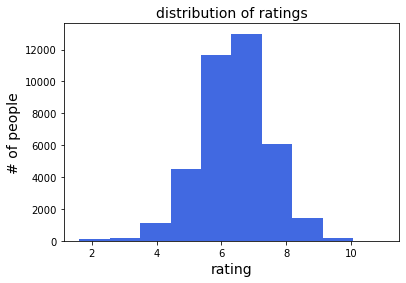

min = 1.62
max = 11.0
mean = 6.3900284298382894
median = 6.400000000000001


In [30]:
plt.hist(trainRec.rate, color="royalblue")
plt.xlabel("rating", fontsize=14)
plt.ylabel("# of people", fontsize=14)
plt.title("distribution of ratings", fontsize=14)
plt.show()
print("min =", min(trainRec.rate))
print("max =", max(trainRec.rate))
print("mean =", np.mean(trainRec.rate))
print("median =", np.median(trainRec.rate))

<font color="royalblue">

### Models

Steps:
- read dataset
- apply different algorithms (here I used SVD, SVD++, NMF and KNN (basic).
- iterate through multiple folds to calculate the mean MSE
- select the model with the lowest average MSE across K folds


</font>

#### SVD

In [31]:
import surprise
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise.accuracy import mse
from surprise.model_selection import KFold


def svd_rec():
    reader = Reader(rating_scale=(min(trainRec.rate), max(trainRec.rate)))
    data = Dataset.load_from_df(trainRec, reader)
    
#   cross-validation iterator
    kf = KFold(n_splits=5)
    algo = SVD()
    scores = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        preds = algo.test(testset)
        scores.append(mse(preds, verbose=True))
    avg_mse = np.mean(scores)
    print("average mse =", avg_mse)
        
svd_rec()

MSE: 0.0483
MSE: 0.0506
MSE: 0.0496
MSE: 0.0511
MSE: 0.0499
average mse = 0.049891634820809674


#### SVD++

In [32]:
from surprise import SVDpp
def svdpp_rec():
    
    reader = Reader(rating_scale=(min(trainRec.rate), max(trainRec.rate)))
    data = Dataset.load_from_df(trainRec, reader)
    
#   cross-validation iterator
    kf = KFold(n_splits=5)
    algo = SVDpp()
    scores = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        preds = algo.test(testset)
        scores.append(mse(preds, verbose=True))
    avg_mse = np.mean(scores)
    print("average mse =", avg_mse)
        
svdpp_rec()

MSE: 0.0349
MSE: 0.0371
MSE: 0.0376
MSE: 0.0345
MSE: 0.0341
average mse = 0.035633853396946316


#### NMF

In [33]:
from surprise import NMF

def nmf_rec():
    
    reader = Reader(rating_scale=(min(trainRec.rate), max(trainRec.rate)))
    data = Dataset.load_from_df(trainRec, reader)
    
#   cross-validation iterator
    kf = KFold(n_splits=5)
    algo = NMF()
    scores = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        preds = algo.test(testset)
        scores.append(mse(preds, verbose=True))
    avg_mse = np.mean(scores)
    print("average mse =", avg_mse)
        
nmf_rec()

MSE: 1.0995
MSE: 1.0145
MSE: 1.0327
MSE: 1.0004
MSE: 0.9975
average mse = 1.028924106257791


#### KNN

In [34]:
from surprise import KNNBasic

def knnbasic_rec():
    
    reader = Reader(rating_scale=(min(trainRec.rate), max(trainRec.rate)))
    data = Dataset.load_from_df(trainRec, reader)
    
#   cross-validation iterator
    kf = KFold(n_splits=5)
    algo = KNNBasic()
    scores = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        preds = algo.test(testset)
        scores.append(mse(preds, verbose=True))
    avg_mse = np.mean(scores)
    print("average mse =", avg_mse)
        
knnbasic_rec()

Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.1982
Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.2005
Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.1859
Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.1850
Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.1828
average mse = 0.1904790541420775


<font color="royalblue">

### Written Conclusion
    
Based on the average MSE across 5-fold cross validation, SVD++ has the best performance and will therefore be used to generate results for the test set. 
    
</font>

### Generate ratings

In [35]:
def best_rec():
    reader = Reader(rating_scale=(min(trainRec.rate), max(trainRec.rate)))
    data = Dataset.load_from_df(trainRec, reader).build_full_trainset()
    algo = SVDpp()
    algo.fit(data)
    preds_ls = []
    index = 0
    for i,j in zip(testRec.pid, testRec.iid):
        if index%2000 == 0:
            print("progress:", index/len(testRec))    
        prediction = algo.predict(uid=i,iid =j)[3]
        preds_ls.append(prediction)
        index += 1
    return preds_ls

pred_rates = best_rec()

progress: 0.0
progress: 0.05209825731329287
progress: 0.10419651462658575
progress: 0.15629477193987862
progress: 0.2083930292531715
progress: 0.26049128656646436
progress: 0.31258954387975724
progress: 0.3646878011930501
progress: 0.416786058506343
progress: 0.46888431581963586
progress: 0.5209825731329287
progress: 0.5730808304462216
progress: 0.6251790877595145
progress: 0.6772773450728073
progress: 0.7293756023861002
progress: 0.7814738596993931
progress: 0.833572117012686
progress: 0.8856703743259788
progress: 0.9377686316392717
progress: 0.9898668889525646


In [36]:
result_table2 = testRec
result_table2["rate"] = pred_rates
result_table2.to_csv("testRec_new.csv", index=False) # will change the name later